In [1]:
import os, sys
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats

from pymongo import MongoClient

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [25]:
# RURL = 'http://146.203.54.74:31871/custom/SigineDMOA'
RURL = 'http://146.203.54.243:31278/custom/SigineDMOA'

def retrieve_creeds_signature(creeds_id, endpoint='fc'):
    CREEDS_API_BASE = 'http://amp.pharm.mssm.edu/creeds-api'
    
    url = '%s/%s/%s' % (CREEDS_API_BASE, endpoint, creeds_id)
    resp = requests.get(url)
    sig = resp.json()

    up_genes = map(lambda x:x[0], sig['up_genes'])
    down_genes = map(lambda x:x[0], sig['down_genes'])
    return up_genes, down_genes

def humanize(up_genes, down_genes):
    '''Convert genes to upper cases.'''
    up_genes = map(lambda x:x.upper(), up_genes)
    down_genes = map(lambda x:x.upper(), down_genes)
    return up_genes, down_genes

def enrich(up_genes, down_genes):
    up_genes, down_genes = humanize(up_genes, down_genes)
    
    config = {"direction":"mimic","combination":False, 'method':'geneSet'}
    headers = {'content-type':'application/json'}
    
    payload = dict([('upGenes', up_genes), ('dnGenes', down_genes)] + config.items())
    response = requests.post(RURL, data=json.dumps(payload),headers=headers)
    result = pd.DataFrame(response.json()).set_index('sig_ids')
    return result

def get_enrich_table(up_genes, down_genes, 
                     mean_ranks=None, std_ranks=None,
                     all_sig_ids=None):
    '''Given input up/down genes, get the result table including 
    columns received from RURL and zscores, combined scores based on 
    mean_ranks, std_ranks.
    '''
    res_df = enrich(up_genes, down_genes)
    res_df = res_df.sort_values('scores', ascending=False)
    res_df['score_ranks'] = np.arange(res_df.shape[0]) + 1

    # sort by sig_id
    res_df = res_df.loc[all_sig_ids]
    res_df['zscores'] = (res_df['score_ranks'] - mean_ranks) / std_ranks
    res_df['combined_scores'] = np.log10(res_df['pvals']) * res_df['zscores']
    return res_df

# Get metadata of CREEDS and L1000FWD signatures

In [4]:
creeds_meta = pd.read_csv('../data/CREEDS_meta.csv').set_index('id')
print creeds_meta.shape
creeds_meta = creeds_meta.query('type=="drug"')
creeds_meta['name'] = creeds_meta['name'].map(lambda x:x.upper())
print creeds_meta.shape
creeds_meta.head()

(3879, 7)
(875, 7)


,name,cell_type,organism,geo_id,pert_ids,ctrl_ids,type
id,,,,,,,
drug:3639,FLUOROURACIL,Bone marrow Sca+ SP hematopoeitic stem cells (...,mouse,GSE1559,GSM26744|GSM26745,GSM26734|GSM26735,drug
drug:3499,RESVERATROL,vastus lateralis muscle,human,GSE32357,GSM801198|GSM801200|GSM801203|GSM801205|GSM801...,GSM801199|GSM801201|GSM801202|GSM801204|GSM801...,drug
drug:3292,CITALOPRAM,lymphoblastoid cells,human,GSE7036,GSM162897|GSM162899|GSM162901,GSM162898|GSM162900|GSM162903,drug
drug:3638,FLUOROURACIL,Bone marrow Sca+ SP hematopoeitic stem cells (...,mouse,GSE1559,GSM26742|GSM26743,GSM26734|GSM26735,drug
drug:3475,ETHANOL,liver,mouse,GSE52644,GSM1273500|GSM1273501|GSM1273502|GSM1273503,GSM1273512|GSM1273513|GSM1273514|GSM1273515,drug


In [5]:
# Get all sig_ids from L1000FWD API
all_sig_ids = requests.get('http://amp.pharm.mssm.edu/L1000FWD/sig_ids')
all_sig_ids = all_sig_ids.json()['sig_ids']
print len(all_sig_ids)

42809


In [6]:
client = MongoClient('mongodb://146.203.54.131:27017/L1000FWD')
coll = client['L1000FWD']['sigs']
cur = coll.find({'sig_id': {'$in': all_sig_ids}}, 
                {'_id':False, 'pert_id':True, 'sig_id':True, 'pert_desc':True})
sig_meta_df = pd.DataFrame.from_records([doc for doc in cur]).set_index('sig_id')
sig_meta_df['pert_desc'] = sig_meta_df['pert_desc'].fillna('NaN').map(lambda x: x.upper())
print sig_meta_df.shape
sig_meta_df.head()

(42809, 2)


,pert_desc,pert_id
sig_id,,
AML001_CD34_6H:BRD-K43389675:10,DAUNORUBICIN,BRD-K43389675
AML001_PC3_6H:BRD-A19037878:0.37037,TRICHOSTATIN_A,BRD-A19037878
AML001_PC3_6H:BRD-A19037878:1.11111,TRICHOSTATIN_A,BRD-A19037878
AML001_PC3_6H:BRD-A19037878:10,TRICHOSTATIN_A,BRD-A19037878
AML001_PC3_6H:BRD-A19037878:3.33333,TRICHOSTATIN_A,BRD-A19037878


In [7]:
print 'number of creeds sigs with matches:',sum(creeds_meta['name'].isin(sig_meta_df['pert_desc']))

number of creeds sigs with matches: 278


# load null scores to compute z-scores

In [8]:
# mat = np.load('../data/null_scores_mat_10000x42809.npy')['mat']
mat = np.load('../data/null_scores_mat_genes_from_Probes_10000x42809.npy')['mat']
print mat.shape

(10000, 42809)


In [9]:
rankmat = np.apply_along_axis(lambda x: stats.rankdata(x, method='ordinal'), 1, mat)
print rankmat.shape
print rankmat.min(), rankmat.max()

(10000, 42809)
1 42809


In [10]:
mean_ranks = rankmat.mean(axis=0)
std_ranks = rankmat.std(axis=0)
print mean_ranks.shape, std_ranks.shape

(42809,) (42809,)


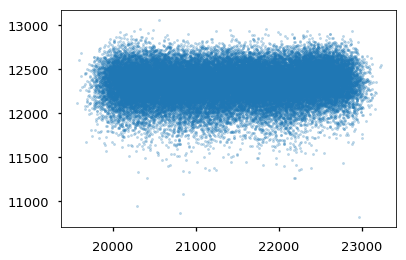

In [11]:
plt.scatter(mean_ranks, std_ranks, s=5, alpha=0.3)

# Matching CREEDS signatures to L1000FWD

In [12]:
# Retrieve a CREEDS signature
creeds_id = creeds_meta.index[1]
up_genes, down_genes = retrieve_creeds_signature(creeds_id)
print len(up_genes), len(down_genes)

300 300


In [15]:
res_df = enrich(up_genes, down_genes)

print res_df.shape
res_df.head()

(42809, 3)


,pvals,qvals,scores
sig_ids,,,
LJP001_MDAMB231_6H:BRD-K68407802-001-02-7:2,1.993289e-20,4.266536e-16,0.118457
CPC013_HCC515_6H:BRD-K58698715-001-05-2:10,1.706927e-15,5.834048e-12,0.101928
CPC006_HA1E_24H:BRD-K09635314-001-02-6:80,1.498621e-13,2.673103e-10,0.093664
CPC006_VCAP_6H:BRD-A30655177-001-08-2:111.11,6.405904e-15,1.958788e-11,0.093664
CPC010_HT29_6H:BRD-K81933000-001-03-3:10,1.771651e-15,5.834048e-12,0.093664


In [16]:
res_df = res_df.sort_values('scores', ascending=False)
res_df['score_ranks'] = np.arange(res_df.shape[0]) + 1

# sort by sig_id
res_df = res_df.loc[all_sig_ids]
res_df['zscores'] = (res_df['score_ranks'] - mean_ranks) / std_ranks

pvals = res_df['pvals'].values
# minimum = np.min(pvals[np.nonzero(pvals)])
# eps = minimum / 1000.

res_df['combined_scores'] = np.log10(res_df['pvals']) * res_df['zscores']
res_df.head()

,pvals,qvals,scores,score_ranks,zscores,combined_scores
sig_ids,,,,,,
AML001_CD34_6H:BRD-K43389675:10,1.000000,1.000000,0.000000,19984,-0.005335,-9.259699e-13
AML001_PC3_6H:BRD-A19037878:0.37037,0.119272,0.538259,-0.027548,37553,1.411782,-1.303725e+00
AML001_PC3_6H:BRD-A19037878:1.11111,0.442941,1.000000,-0.022039,35492,1.228703,-4.345359e-01
AML001_PC3_6H:BRD-A19037878:10,0.545468,1.000000,-0.019284,33685,1.100572,-2.897041e-01
AML001_PC3_6H:BRD-A19037878:3.33333,0.596334,1.000000,-0.016529,32083,0.989472,-2.221468e-01


In [17]:
res_df.sort_values('pvals',ascending=True).head(10)

,pvals,qvals,scores,score_ranks,zscores,combined_scores
sig_ids,,,,,,
CPC001_VCAP_24H:BRD-K07212038-001-02-1:10,1.769699e-21,7.575905e-17,-0.115702,42809,1.883184,-39.080027
LJP001_MDAMB231_6H:BRD-K68407802-001-02-7:2,1.993289e-20,4.266536e-16,0.118457,1,-1.773245,34.933691
CPC006_VCAP_6H:BRD-A56592690-001-01-9:30,3.377847e-20,4.820075e-16,-0.112948,42807,1.817953,-35.398022
CPC013_HT29_6H:BRD-A94381689-001-01-4:10,7.686917e-20,8.226731e-16,-0.112948,42808,1.728980,-33.048149
CPC016_HEPG2_6H:BRD-A06352508-001-02-9:10,1.671040e-19,1.430711e-15,-0.110193,42806,1.726097,-32.410947
CPC012_A549_24H:BRD-K95760042-001-02-6:10,4.200507e-19,2.845480e-15,-0.107438,42803,1.797947,-33.040321
CPC002_VCAP_24H:BRD-K43245338-001-02-4:10,4.652844e-19,2.845480e-15,-0.110193,42804,1.799802,-32.994486
CPC015_HT29_6H:BRD-A10715913-001-03-8:10,1.539634e-18,8.238772e-15,-0.110193,42805,1.695941,-30.209095
CPC016_NPC_24H:BRD-K81729199-001-01-0:10,6.030923e-17,2.868642e-13,-0.104683,42802,1.675802,-27.180865


In [18]:
res_df.sort_values('combined_scores',ascending=False).head(10)

,pvals,qvals,scores,score_ranks,zscores,combined_scores
sig_ids,,,,,,
LJP001_MDAMB231_6H:BRD-K68407802-001-02-7:2,1.993289e-20,4.266536e-16,0.118457,1,-1.773245,34.933691
CPC010_HT29_6H:BRD-K81933000-001-03-3:10,1.771651e-15,5.834048e-12,0.093664,5,-1.729035,25.506073
CPC013_HCC515_6H:BRD-K58698715-001-05-2:10,1.706927e-15,5.834048e-12,0.101928,2,-1.674654,24.730925
CPC017_HT29_6H:BRD-K14441456-001-01-2:10,7.425269e-14,1.513659e-10,0.085399,13,-1.856944,24.380353
LJP001_MCF7_6H:BRD-K19687926-379-03-3:2,1.369680e-13,2.549331e-10,0.088154,11,-1.874670,24.114598
CPC006_VCAP_6H:BRD-A30655177-001-08-2:111.11,6.405904e-15,1.958788e-11,0.093664,4,-1.695192,24.060566
CPC009_HCC515_6H:BRD-K21773564-001-01-8:10,5.452173e-14,1.228432e-10,0.090909,6,-1.706098,22.628712
CPC014_MCF7_6H:BRD-K98372770-001-04-1:10,2.318358e-13,3.817177e-10,0.088154,10,-1.758619,22.219838
CPC014_MCF7_24H:BRD-A36707673-001-01-9:10,5.729927e-13,7.912659e-10,0.088154,9,-1.729474,21.171965


In [19]:
res_df.sort_values('scores',ascending=False).head(10)

,pvals,qvals,scores,score_ranks,zscores,combined_scores
sig_ids,,,,,,
LJP001_MDAMB231_6H:BRD-K68407802-001-02-7:2,1.993289e-20,4.266536e-16,0.118457,1,-1.773245,34.933691
CPC013_HCC515_6H:BRD-K58698715-001-05-2:10,1.706927e-15,5.834048e-12,0.101928,2,-1.674654,24.730925
CPC006_HA1E_24H:BRD-K09635314-001-02-6:80,1.498621e-13,2.673103e-10,0.093664,3,-1.605735,20.592441
CPC010_HT29_6H:BRD-K81933000-001-03-3:10,1.771651e-15,5.834048e-12,0.093664,5,-1.729035,25.506073
CPC006_VCAP_6H:BRD-A30655177-001-08-2:111.11,6.405904e-15,1.958788e-11,0.093664,4,-1.695192,24.060566
CPC009_HCC515_6H:BRD-K21773564-001-01-8:10,5.452173e-14,1.228432e-10,0.090909,6,-1.706098,22.628712
CPC014_MCF7_24H:BRD-A36707673-001-01-9:10,5.729927e-13,7.912659e-10,0.088154,9,-1.729474,21.171965
CPC014_HCC515_6H:BRD-K53972329-001-01-3:10,1.599326e-12,1.801725e-09,0.088154,8,-1.722430,20.317896
LJP001_MCF7_6H:BRD-K19687926-379-03-3:2,1.369680e-13,2.549331e-10,0.088154,11,-1.874670,24.114598


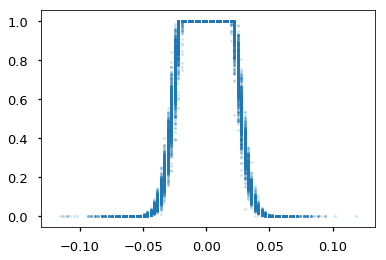

In [20]:
fig, ax = plt.subplots()
ax.scatter(res_df['scores'], res_df['qvals'],
          s=5,
          alpha=0.2)



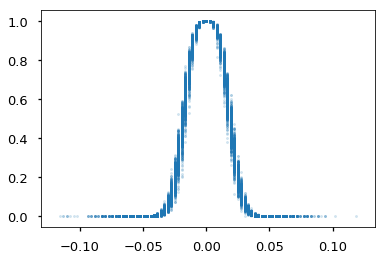

In [21]:
fig, ax = plt.subplots()
ax.scatter(res_df['scores'], res_df['pvals'],
          s=5,
          alpha=0.2)


In [22]:
print res_df['pvals'].min(), res_df['qvals'].min()

1.76969918404e-21 7.57590523695e-17


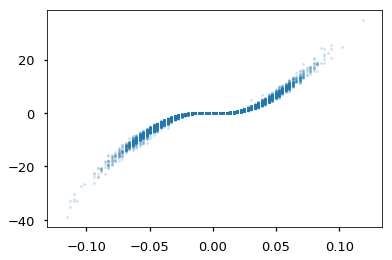

In [23]:
fig, ax = plt.subplots()
ax.scatter(res_df['scores'], res_df['combined_scores'],
          s=5,
          alpha=0.2)

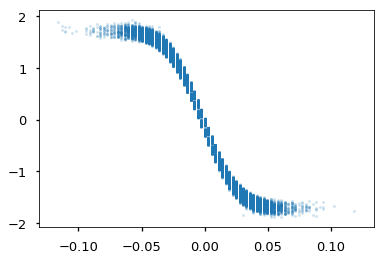

In [24]:
fig, ax = plt.subplots()
ax.scatter(res_df['scores'], res_df['zscores'],
          s=5,
          alpha=0.2)

# Match CREEDS signatures to L1000

In [26]:
creeds_id_with_matches = creeds_meta.loc[creeds_meta['name'].isin(sig_meta_df['pert_desc'])].index
print len(creeds_id_with_matches)

278


In [32]:
drug_name = creeds_meta.loc[creeds_id, 'name']
matching_sig_ids = sig_meta_df.query('pert_desc == "%s"' % drug_name).index
print len(matching_sig_ids)

34


In [37]:
np.where(np.in1d(res_df.index, matching_sig_ids))[0] + 1

array([  402,   530,   660,   778,   890,  1023,  1193,  1390,  6687,
        8981, 10104, 10808, 34011, 34012, 34013, 34045, 34046, 34047,
       34080, 34081, 34082, 34083, 34118, 34119, 34120, 34121, 34122,
       41279, 41420, 42720, 42721, 42758, 42783, 42802])

In [28]:
cols_for_ranking = [
    {'col':'scores', 'ascending':False},
    {'col':'zscores', 'ascending':True},
    {'col':'combined_scores', 'ascending':False},
]


In [69]:
d_scaled_ranks = {
    'scores': [],
    'zscores': [],
    'combined_scores': []
}
d_ranks = {
    'scores': {},
    'zscores': {},
    'combined_scores': {}    
}


for c, creeds_id in enumerate(creeds_id_with_matches):
    drug_name = creeds_meta.loc[creeds_id, 'name']
    matching_sig_ids = sig_meta_df.query('pert_desc == "%s"' % drug_name).index
    up_genes, down_genes = retrieve_creeds_signature(creeds_id, endpoint='fc')
    res_df = get_enrich_table(up_genes, down_genes,
                              mean_ranks=mean_ranks, std_ranks=std_ranks,
                              all_sig_ids=all_sig_ids)
    
    for col_rec in cols_for_ranking:
        res_df = res_df.sort_values([col_rec['col']], ascending=col_rec['ascending'])
        ranks = np.where(np.in1d(res_df.index, matching_sig_ids))[0] + 1
        d_ranks[col_rec['col']][creeds_id] = ranks
        scaled_ranks = ranks/float(len(all_sig_ids))
        
        d_scaled_ranks[col_rec['col']].extend(list(scaled_ranks))
    if c % 20 == 0:
        print c, len(creeds_id_with_matches)

0 278
20 278
40 278
60 278
80 278
100 278
120 278
140 278
160 278
180 278
200 278
220 278
240 278
260 278


In [39]:
sys.path.append('/Users/maayanlab/Documents/bitbucket/maayanlab_utils/')
from plot_DRR import *

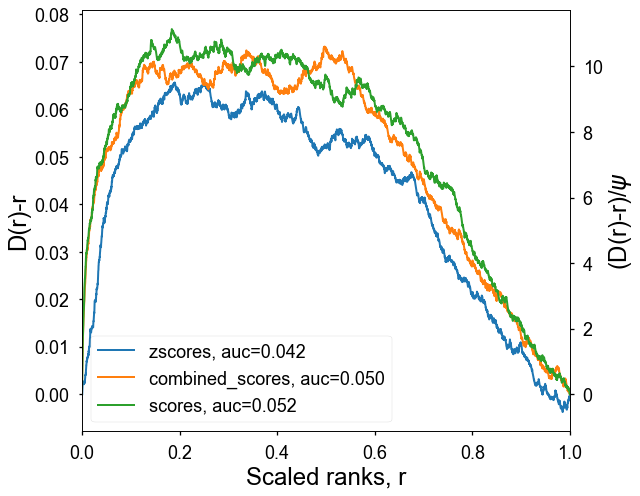

In [55]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax_right = ax.twinx()
for key, vals in d_scaled_ranks.items():
    plt_DRR(vals, ax, ax_right, label=key, ls='-')
    
ax.legend(loc='best', prop={'size':18})
fig.tight_layout()
fig.savefig('figures/DRR_creeds_FC600.pdf')

In [70]:
d_scaled_ranks = {
    'scores': [],
    'zscores': [],
    'combined_scores': []
}
d_ranks_limma = {
    'scores': {},
    'zscores': {},
    'combined_scores': {}    
}

for c, creeds_id in enumerate(creeds_id_with_matches):
    drug_name = creeds_meta.loc[creeds_id, 'name']
    matching_sig_ids = sig_meta_df.query('pert_desc == "%s"' % drug_name).index
    up_genes, down_genes = retrieve_creeds_signature(creeds_id, endpoint='limma/limma_norm')
    if len(up_genes)>5 and len(down_genes)> 5:
        res_df = get_enrich_table(up_genes, down_genes,
                                  mean_ranks=mean_ranks, std_ranks=std_ranks,
                                  all_sig_ids=all_sig_ids)

        for col_rec in cols_for_ranking:
            res_df = res_df.sort_values([col_rec['col']], ascending=col_rec['ascending'])
            ranks = np.where(np.in1d(res_df.index, matching_sig_ids))[0] + 1
            d_ranks_limma[col_rec['col']][creeds_id] = ranks            
            scaled_ranks = ranks/float(len(all_sig_ids))

            d_scaled_ranks[col_rec['col']].extend(list(scaled_ranks))
    if c % 20 == 0:
        print c, len(creeds_id_with_matches)

0 278
20 278
40 278
60 278
80 278
100 278
120 278
140 278
160 278
180 278
200 278
220 278
240 278
260 278


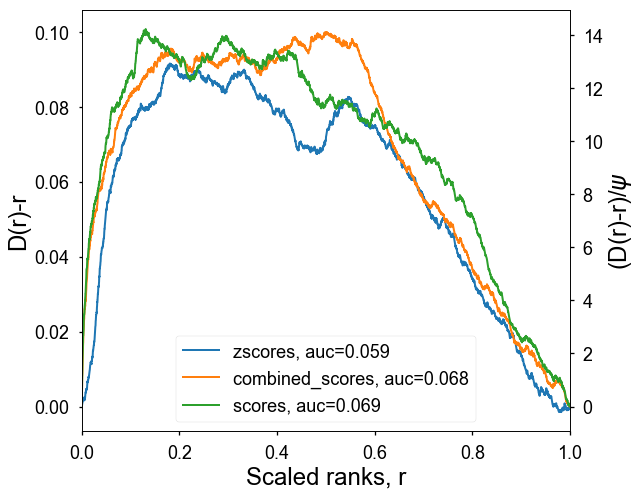

In [62]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax_right = ax.twinx()
for key, vals in d_scaled_ranks.items():
    plt_DRR(vals, ax, ax_right, label=key, ls='-')
    
ax.legend(loc='best', prop={'size':18})
fig.tight_layout()
fig.savefig('figures/DRR_creeds_limma_norm.pdf')

In [84]:
d_scaled_ranks = {
    'scores': [],
    'zscores': [],
    'combined_scores': []
}
d_ranks_cd_sva2 = {
    'scores': {},
    'zscores': {},
    'combined_scores': {}        
}

for c, creeds_id in enumerate(creeds_id_with_matches):
    drug_name = creeds_meta.loc[creeds_id, 'name']
    matching_sig_ids = sig_meta_df.query('pert_desc == "%s"' % drug_name).index
    up_genes, down_genes = retrieve_creeds_signature(creeds_id, endpoint='cd/chdir_sva_exp2')
    res_df = get_enrich_table(up_genes, down_genes,
                              mean_ranks=mean_ranks, std_ranks=std_ranks,
                              all_sig_ids=all_sig_ids)
    
    for col_rec in cols_for_ranking:
        res_df = res_df.sort_values([col_rec['col']], ascending=col_rec['ascending'])
        ranks = np.where(np.in1d(res_df.index, matching_sig_ids))[0] + 1
        d_ranks_cd_sva2[col_rec['col']][creeds_id] = ranks        
        scaled_ranks = ranks/float(len(all_sig_ids))
        
        d_scaled_ranks[col_rec['col']].extend(list(scaled_ranks))
    if c % 20 == 0:
        print c, len(creeds_id_with_matches)

0 278
20 278
40 278
60 278
80 278
100 278
120 278
140 278
160 278
180 278
200 278
220 278
240 278
260 278


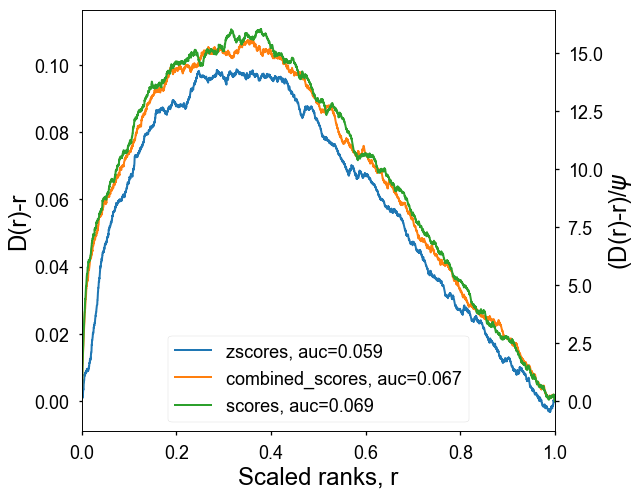

In [65]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax_right = ax.twinx()
for key, vals in d_scaled_ranks.items():
    plt_DRR(vals, ax, ax_right, label=key, ls='-')
    
ax.legend(loc='best', prop={'size':18})
fig.tight_layout()
fig.savefig('figures/DRR_creeds_chdir_sva_exp2.pdf')

In [72]:
d_scaled_ranks = {
    'scores': [],
    'zscores': [],
    'combined_scores': []
}
d_ranks_cd = {
    'scores': {},
    'zscores': {},
    'combined_scores': {}        
}


for c, creeds_id in enumerate(creeds_id_with_matches):
    drug_name = creeds_meta.loc[creeds_id, 'name']
    matching_sig_ids = sig_meta_df.query('pert_desc == "%s"' % drug_name).index
    up_genes, down_genes = retrieve_creeds_signature(creeds_id, endpoint='cd/chdir')
    res_df = get_enrich_table(up_genes, down_genes,
                              mean_ranks=mean_ranks, std_ranks=std_ranks,
                              all_sig_ids=all_sig_ids)
    
    for col_rec in cols_for_ranking:
        res_df = res_df.sort_values([col_rec['col']], ascending=col_rec['ascending'])
        ranks = np.where(np.in1d(res_df.index, matching_sig_ids))[0] + 1
        d_ranks_cd_sva[col_rec['col']][creeds_id] = ranks
        scaled_ranks = ranks/float(len(all_sig_ids))
        
        d_scaled_ranks[col_rec['col']].extend(list(scaled_ranks))
    if c % 20 == 0:
        print c, len(creeds_id_with_matches)

0 278
20 278
40 278
60 278
80 278
100 278
120 278
140 278
160 278
180 278
200 278
220 278
240 278
260 278


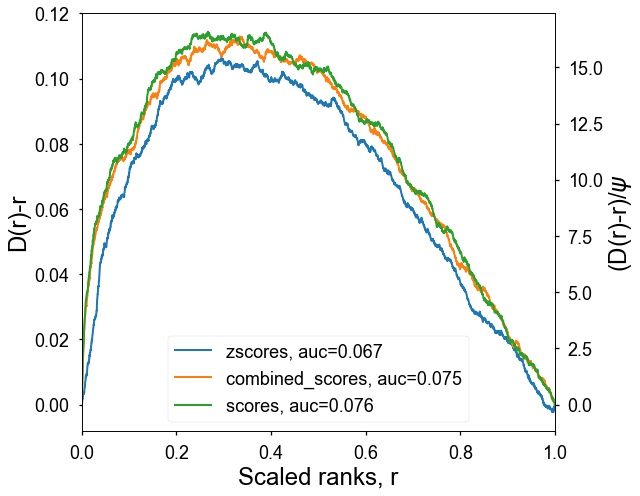

In [67]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax_right = ax.twinx()
for key, vals in d_scaled_ranks.items():
    plt_DRR(vals, ax, ax_right, label=key, ls='-')
    
ax.legend(loc='best', prop={'size':18})
fig.tight_layout()
fig.savefig('figures/DRR_creeds_chdir.pdf')

2133.0
25


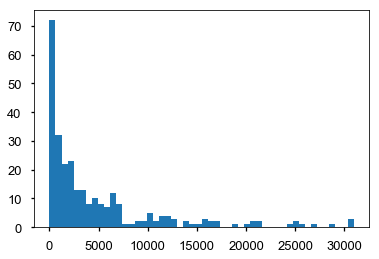

In [86]:
# Plot hists of the first ranks from each creeds_id
# fold change
min_ranks = [min(ranks) for ranks in d_ranks['scores'].values()]
plt.hist(min_ranks, bins=50);
print np.median(min_ranks)
print (np.array(min_ranks) < 100).sum()

2032.0
30


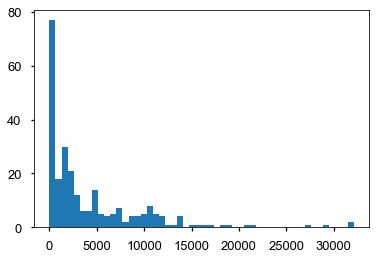

In [87]:
min_ranks = [min(ranks) for ranks in d_ranks_limma['scores'].values()]
plt.hist(min_ranks, bins=50);
print np.median(min_ranks)
print (np.array(min_ranks) < 100).sum()

1547.0
28


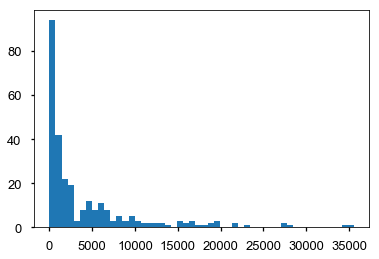

In [88]:
# chdir
min_ranks = [min(ranks) for ranks in d_ranks_cd_sva['scores'].values()]
plt.hist(min_ranks, bins=50);
print np.median(min_ranks)
print (np.array(min_ranks) < 100).sum()

1573.0
31


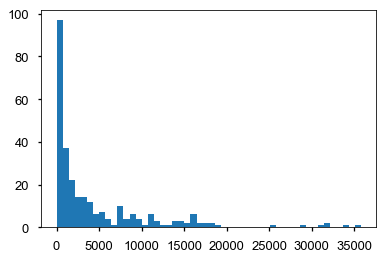

In [89]:
# chdir_sva_exp2
min_ranks = [min(ranks) for ranks in d_ranks_cd_sva2['scores'].values()]
plt.hist(min_ranks, bins=50);
print np.median(min_ranks)
print (np.array(min_ranks) < 100).sum()

In [91]:
creeds_ids_with_good_matches = [cid 
                                for cid, ranks in d_ranks_cd_sva2['scores'].items() 
                                if min(ranks) < 100
                               ]
creeds_meta.loc[creeds_ids_with_good_matches] 

,name,cell_type,organism,geo_id,pert_ids,ctrl_ids,type
id,,,,,,,
drug:2645,MLN4924,A375 melanoma cell line - 4 Hours,human,GSE30531,GSM757134|GSM757135|GSM757136,GSM757119|GSM757120|GSM757121,drug
drug:2647,MLN4924,A375 melanoma cell line - 24 Hours,human,GSE30531,GSM757140|GSM757141|GSM757142,GSM757125|GSM757126|GSM757127,drug
drug:3407,CURCUMIN,U937 monoctyes exposed to oxidative stress - 4...,human,GSE10896,GSM276212|GSM276220|GSM276228,GSM276211|GSM276219|GSM276227,drug
drug:3505,RESVERATROL,neocortex,mouse,GSE11291,GSM285022|GSM285023|GSM285024|GSM285025|GSM285026,GSM285012|GSM285013|GSM285014|GSM285015|GSM285016,drug
drug:3059,CYCLOHEXIMIDE,MCF-7 BREAST CANCER cell line,human,GSE8597,GSM213322|GSM213323|GSM213324|GSM213325,GSM213330|GSM213331|GSM213332|GSM213333,drug
drug:2691,CHLORAMBUCIL,NaN,human,GSE8832,GSM219395|GSM219396|GSM219397,GSM219392|GSM219393|GSM219394,drug
drug:2734,ESTRADIOL,eralpha,human,GSE1153,GSM19292|GSM19293,GSM19191|GSM19291,drug
drug:3633,TRETINOIN,cranial neural crest - 24 Hours,mouse,GSE1588,GSM27267|GSM27268|GSM27269|GSM27270,GSM27263|GSM27264|GSM27265|GSM27266,drug
drug:2732,ESTRADIOL,NaN,human,GSE24592,GSM606110|GSM606111|GSM606112,GSM606107|GSM606108|GSM606109,drug
